In [169]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib import cm

from PIL import Image

<div style="text-align: center;">
    <span style="color: red; font-size: 80px;"> Esperienza 1 </span>
</div>

<div style="text-align: center;">
    <span style="color: blue; font-size: 60px;"> Calibrazione </span>
</div>

<div style="text-align: center;">
    <span style="color: grey; font-size: 45px;"> Studio delle immagini </span>
</div>

Le istantanee di plasma prese in fase di calibrazione sono 32: avendole aperte tutte posso affermare con certezza che nessuna delle immagini è corrotta. Procedo ad effettuare lo studio delle immagini considerandole tutte.

In [170]:
col = 1224
row = 1024

Le funzioni che verranno utilizzate per la pulizia sono le stesse che utilizzavo nel notebook dell'esperienza zero, ossia quella di calibrazione della trappola di Malberg-Penning ElTrap.

In [171]:
# Function to compute mean noise
def mean_noise(base, num_im):
    appo = 0
    m_noise = 0

    for i in range(1, num_im + 1):
        path = base + "{:03d}".format(i) + ".tif"
        m_noise = m_noise * i/(i+1) + np.array(Image.open(path))/(i+1)

    del appo
    return m_noise


# Function to set outside pixel to zero
def est_nullo(plasma, mean_noise, radius, xcen, ycen):
    x = np.linspace(-xcen, col - xcen, col)
    y = np.linspace(-ycen, row - ycen, row)

    # Creating mash grid to check wether we are in trap or not
    X, Y = np.meshgrid(x, y)
    
    plasma = plasma - mean_noise

    mask = plasma < 0
    plasma[mask] = 0

    mask = (X*X + Y*Y) > pow(radius, 2)
    plasma[mask] = 0

    del mask, x, y, X, Y
    return plasma


# Function to reduce additional noise
def no_rifl(plasma, r_pl, r_trap, xcen, ycen):
    x = np.linspace(-xcen, col - xcen, col)
    y = np.linspace(-ycen, row - ycen, row)

    X, Y = np.meshgrid(x, y)

    mask = ((X*X + Y*Y) < pow(r_trap, 2)) & ((X*X + Y*Y) > pow(r_pl, 2))
    appo = np.mean(plasma[mask])

    mask = (X*X + Y*Y) < pow(r_trap, 2)
    plasma[mask] = plasma[mask] - appo

    mask = plasma < 0
    plasma[mask] = 0
    
    del x, y, X, Y, appo, mask
    return plasma


<center>

### Stampa delle immagini pulite

</center>

In [172]:
rum_med = mean_noise("Dati/CAMimages/dark/dark", 80) 
xcen = 612; ycen = 502; r_pl = 320; rtrap = 419

conta = 1
for i in range(1, 33):

    path = "Dati/CAMimages/calibrazione/calibplasma" + "{:03d}".format(i) + ".tif"

    plasma = np.array(Image.open(path))
    plasma = plasma.reshape(1024, 1224)

    plasma = est_nullo(plasma, rum_med, rtrap, xcen, ycen)
    plasma = no_rifl(plasma, r_pl, rtrap, xcen, ycen)

    # Salvo l'immagine
    path = "Dati/CAMimages/plasma_pulite/plasma" + "{:03d}".format(conta) + ".tif"

    image = Image.fromarray(plasma)
    image.save(path)
    conta += 1

del rum_med, plasma, image, conta
del xcen, ycen, r_pl, rtrap, path

<center>

### Calcolo dell'intensità media

</center>

In [173]:
int_media = 0

for i in range(1, 33):
    path = "Dati/CAMimages/plasma_pulite/plasma" + "{:03d}".format(i) + ".tif"
    plasma = np.array(Image.open(path))
    plasma = plasma.reshape(1024, 1224)

    int_media = int_media * (i-1)/i + sum(sum(plasma))/i

del path, plasma
print("L'intensità media delle immagini di plasma è: ", int(int_media))

L'intensità media delle immagini di plasma è:  31620138


<div style="text-align: center;">
    <span style="color: grey; font-size: 45px;"> Studio della scarica </span>
</div>

In [174]:
def moving_av(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def exp_func(x, a, b):
    return a * np.exp(b * x)

<center>

### Scarica ionica

</center>

I venti segnali di scarica ionica sono tutti simili fra loro e non presentano criticità. Per questo motivo per quantificare la carica positiva presente nella trappola, utilizzo tutti i venti segnali.

In [175]:
udm_v = 1e-3; udm_t = 1e-3
res = 1e6; car_ioni = []

for i in range(1, 21):

    #----------------------------------------#
    #          Lettura file di input         #
    #----------------------------------------#
    filename = 'Dati/Signals/calibration/idischarge/idischarge_' + "{:02d}".format(i) + '.txt'

    data = pd.read_csv(filename, delim_whitespace=True, skiprows=3, header=None)
    t = data[0].astype(float) * udm_t; v = data[1].astype(float) * udm_v


    #----------------------------------------#
    #      Calcolo offset e sottrazione      #
    #----------------------------------------#
    v_off = np.mean(v[:30000])
    v = v - v_off


    #----------------------------------------#
    #          Smoothing del segnale         #
    #----------------------------------------#      
    v_smooth = moving_av(v, window_size = 100)
    t = t[:len(v_smooth)]


    #----------------------------------------#
    #             Fit esponenziale           #
    #----------------------------------------#   
    t_fit = t[41000:60000]
    popt, pcov = curve_fit(exp_func, t_fit, v_smooth[41000:60000])
    a, b = popt


    #----------------------------------------#
    #          Calcolo della carica          #
    #----------------------------------------#
    mask = t > 0; dt = t[155] - t[154]; cap = -1.0/(b * res)
    car_ioni.append(np.sum(v_smooth[mask]) * dt/res + np.mean(v_smooth[len(v_smooth) - 101 : len(v_smooth) - 1]) * cap)

car_ioni = np.array(car_ioni)
print("La carica media della popolazione ionica risulta: " + str(round(np.mean(car_ioni), 13))+ r" +/- " + str(round(np.std(car_ioni), 13)) + " C")
del res, udm_v, udm_t, mask, dt, a, b, t_fit, t, v, v_smooth, cap

La carica media della popolazione ionica risulta: 1.35e-11 +/- 7e-13 C


<center>

### Scarica elettronica

</center>

I ventisei segnali di scarica elettronica sono tutti simili fra loro e non presentano criticità. Per questo motivo per quantificare la carica presente nella trappola, utilizzo tutti i venti segnali.

In [176]:
udm_v = 1; udm_t = 1e-3
res = 1e6; car_ele = []

for i in range(1, 27):


    #----------------------------------------#
    #          Lettura file di input         #
    #----------------------------------------#
    filename = 'Dati/Signals/calibration/edischarge/edischarge_' + "{:02d}".format(i) + '.txt'

    data = pd.read_csv(filename, delim_whitespace=True, skiprows=3, header=None)
    t = data[0].astype(float) * udm_t; v = data[1].astype(float) * udm_v


    #----------------------------------------#
    #      Calcolo offset e sottrazione      #
    #----------------------------------------#
    v_off = np.mean(v[:30000])
    v = v - v_off


    #----------------------------------------#
    #          Smoothing del segnale         #
    #----------------------------------------#      
    v_smooth = moving_av(v, window_size = 100)
    t = t[:len(v_smooth)]


    #----------------------------------------#
    #             Fit esponenziale           #
    #----------------------------------------#   
    t_fit = t[41000:60000]
    popt, pcov = curve_fit(exp_func, t_fit, v_smooth[41000:60000])
    a, b = popt


    #----------------------------------------#
    #          Calcolo della carica          #
    #----------------------------------------#
    mask = t > 0; dt = t[155] - t[154]; cap = -1.0/(b * res)
    car_ele.append(np.sum(v_smooth[mask]) * dt/res + np.mean(v_smooth[len(v_smooth) - 101 : len(v_smooth) - 1]) * cap)

car_ele = np.array(car_ele)
print("La carica media della popolazione elettronica risulta: " + str(round(np.mean(car_ele) - np.mean(car_ioni), 13))+ r" +/- " + str(round(np.std(car_ele - np.mean(car_ioni)), 13)) + " C")
del res, udm_v, udm_t, mask, dt, a, b, t_fit, t, v, v_smooth, cap, car_ioni

La carica media della popolazione elettronica risulta: -1.2516e-09 +/- 1.55e-11 C


<center>

### Fattore di conversione

</center>

In [177]:
conv_fact = np.mean(car_ele)/int_media
print("Il fattore di conversione fra intensità del singolo pixel e carica è pari a: ", round(conv_fact, 20))
del car_ele, int_media

Il fattore di conversione fra intensità del singolo pixel e carica è pari a:  -3.916e-17


<div style="text-align: center;">
    <span style="color: blue; font-size: 60px;"> Studio degli offset </span>
</div>

<div style="text-align: center;">
    <span style="color: grey; font-size: 45px;"> Offset ottici </span>
</div>

Per prima cosa voglio pulire le immagini: chiaramente devo stare attento a come tolgo il rumore dovuto alle riflessioni perchè la colonna di plasma non si trova più al centro della immagine stessa. Le immagini presenti nella cartella Esperienza 1 sono già state in parte pulite utilizzando uno script di matlab, l'ultima cosa che manca da fare è togliere le riflessioni. Per questo motivo definisco una nuova procedura che consente di settare un limite massimo dall'esterno all'intensità dei pixel da considerarsi come affetti dal solo rumore.

In [331]:
# Function to reduce additional noise
def no_rifl_off(plasma, r_trap, x, y, intlim):

    X, Y = np.meshgrid(x, y)

    mask = plasma < intlim
    appo = np.mean(plasma[mask])

    mask = (X*X + Y*Y) < pow(r_trap, 2)
    plasma[mask] = plasma[mask] - appo

    mask = plasma < 0
    plasma[mask] = 0
    
    del x, y, X, Y, appo, mask
    return plasma

def off_ottico(path, rip, r_trap, xcen, ycen, intlim):
    
    x = np.linspace(-xcen, col - xcen, col)
    y = np.linspace(-ycen, row - ycen, row)

    X, Y = np.meshgrid(x, y)
    off_opt = 0

    # Ciclo sulle immagini di plasma ripetibili
    for i in range(0, len(rip)):
        fname = path + "{:03d}".format(rip[i]) + '.tif'
        plasma = np.array(Image.open(fname))
        plasma = plasma.reshape(1024, 1224)
        plasma = no_rifl_off(plasma, r_trap, x, y, intlim)

        # Calcolo l'offset come una media pesata sull intensità dei pixels
        appo = np.sqrt(pow(np.sum(plasma * X)/np.sum(plasma), 2) + pow(np.sum(plasma * Y)/np.sum(plasma), 2))

        off_opt = off_opt * i/(i+1) + appo/(i+1)
    
    del X, Y, x, y, appo, fname
    return off_opt

<center>

### Evoluzione libera: 175 ms

</center>

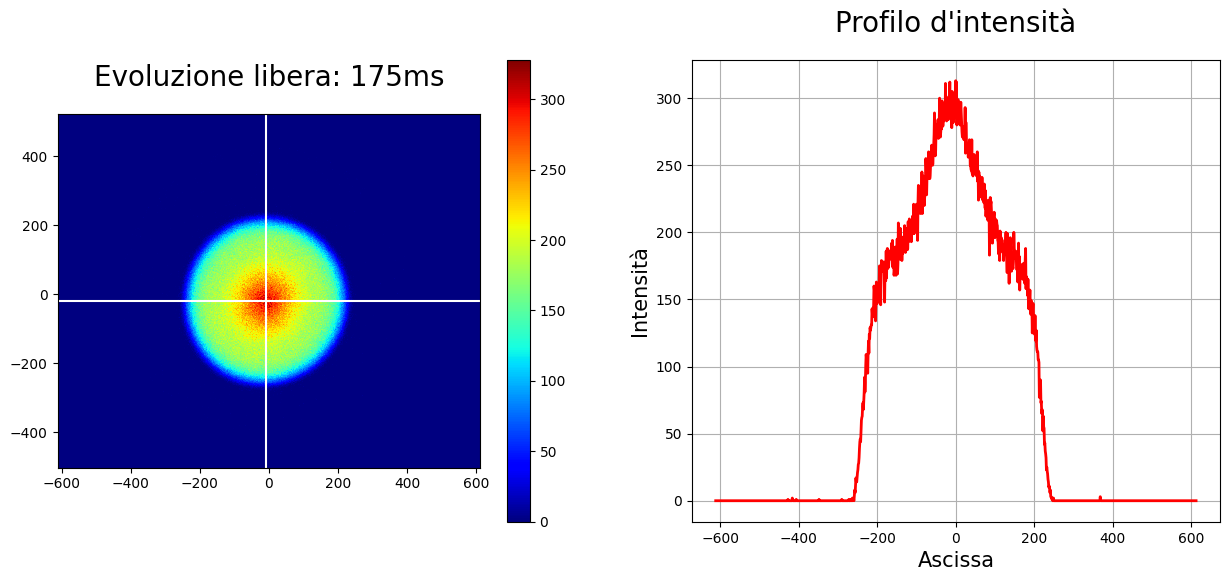

In [501]:
#--------------------------------------------------#
#     Testo i metodi --> prima fase di pulizia     #
#--------------------------------------------------#
xcen = 612; ycen = 502; r_pl = 320; rtrap = 419

rum_med = mean_noise("Dati/CAMimages/dark/dark", 80) 

plasma = np.array(Image.open("Dati/CAMimages/series7_175ms/plasma007.tif"))
plasma = plasma.reshape(1024, 1224)

x = np.linspace(-xcen, col - xcen, col)
y = np.linspace(-ycen, row - ycen, row)

plasma = no_rifl_off(plasma, rtrap, x, y, 10)



#--------------------------------------------------------------#
#     Testo i metodi --> output per visualizzare risultati     #
#--------------------------------------------------------------#

fig = plt.figure(figsize=(15, 6))

x = np.linspace(-xcen, col - xcen, col)
y = np.linspace(-ycen, row - ycen, row)

X, Y = np.meshgrid(x, y)

#-------------------------------------------------------------#
#              Immagine di plasma: esterno nullo              #
#-------------------------------------------------------------# 
ax = fig.add_subplot(1, 2, 1)

cax = ax.pcolormesh(X, Y, plasma, cmap='jet')
plt.colorbar(cax); ax.set_aspect('equal')
ax.set_title(f'Evoluzione libera: 175ms', fontsize = 20, pad = 20)
plt.axhline(y=-20, color='w', linestyle='-')
plt.axvline(x=-10, color='w', linestyle='-')

#-------------------------------------------------------------#
#                      Profilo d'intensità                    #
#-------------------------------------------------------------# 
ax = fig.add_subplot(1, 2, 2); prof = plasma[482,:]

ax.plot(x, prof, color = 'r', linestyle = '-',linewidth = 2)
ax.set_xlabel("Ascissa", fontsize = 15); ax.set_ylabel("Intensità", fontsize = 15); ax.grid(True)
ax.set_title(f"Profilo d'intensità", fontsize = 20, pad = 20)

plt.show()

del x, y, X, Y
del prof, plasma, rum_med
del xcen, ycen, r_pl, rtrap

Procediamo ora con il calcolo dell'offset con 175 ms di evoluzione libera. Individuo aprendo uno ad uno i segnali indotti sul settore S2B in modo tale da identificare quali risultino ripertibili e quali no.

In [502]:
rip175 = [1, 2, 4, 5, 6, 7, 8, 9, 10]

In [503]:
xcen = 612; ycen = 502; intlim = 10; rtrap = 419
off_175 = off_ottico('Dati/CAMimages/series7_175ms/plasma', rip175, rtrap, xcen, ycen, intlim)

print("L'offset medio con 200 ms di evoluzione libera è pari a: ", round(off_175, 4))
del xcen, ycen, intlim, rtrap

L'offset medio con 200 ms di evoluzione libera è pari a:  16.0178


<center>

### Evoluzione libera: 200 ms

</center>

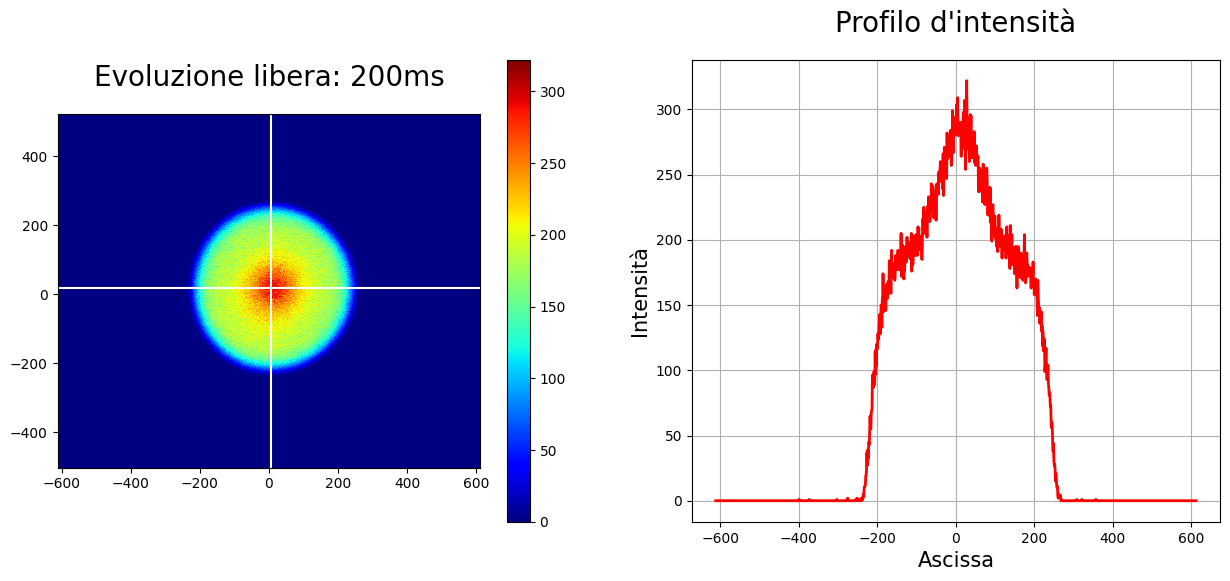

In [341]:
#--------------------------------------------------#
#     Testo i metodi --> prima fase di pulizia     #
#--------------------------------------------------#
xcen = 612; ycen = 502; r_pl = 320; rtrap = 419

rum_med = mean_noise("Dati/CAMimages/dark/dark", 80) 

plasma = np.array(Image.open("Dati/CAMimages/series1_200ms/plasma010.tif"))
plasma = plasma.reshape(1024, 1224)

x = np.linspace(-xcen, col - xcen, col)
y = np.linspace(-ycen, row - ycen, row)

plasma = no_rifl_off(plasma, rtrap, x, y, 10)



#--------------------------------------------------------------#
#     Testo i metodi --> output per visualizzare risultati     #
#--------------------------------------------------------------#

fig = plt.figure(figsize=(15, 6))

x = np.linspace(-xcen, col - xcen, col)
y = np.linspace(-ycen, row - ycen, row)

X, Y = np.meshgrid(x, y)

#-------------------------------------------------------------#
#              Immagine di plasma: esterno nullo              #
#-------------------------------------------------------------# 
ax = fig.add_subplot(1, 2, 1)

cax = ax.pcolormesh(X, Y, plasma, cmap='jet')
plt.colorbar(cax); ax.set_aspect('equal')
ax.set_title(f'Evoluzione libera: 200ms', fontsize = 20, pad = 20)
plt.axhline(y=18, color='w', linestyle='-')
plt.axvline(x=7, color='w', linestyle='-')

#-------------------------------------------------------------#
#                      Profilo d'intensità                    #
#-------------------------------------------------------------# 
ax = fig.add_subplot(1, 2, 2); prof = plasma[520,:]

ax.plot(x, prof, color = 'r', linestyle = '-',linewidth = 2)
ax.set_xlabel("Ascissa", fontsize = 15); ax.set_ylabel("Intensità", fontsize = 15); ax.grid(True)
ax.set_title(f"Profilo d'intensità", fontsize = 20, pad = 20)

plt.show()

del x, y, X, Y
del prof, plasma, rum_med
del xcen, ycen, r_pl, rtrap

Procediamo ora con il calcolo dell'offset con 200 ms di evoluzione libera. Individuo aprendo uno ad uno i segnali indotti sul settore S2B in modo tale da identificare quali risultino ripertibili e quali no.

In [320]:
rip200 = [2, 4, 5, 6, 7, 10, 11, 14, 15, 16, 17, 18, 21, 22, 24, 29, 30, 31, 32, 33, 34, 35, 38, 39, 40, 41, 43, 47, 48, 49]

In [333]:
xcen = 612; ycen = 502; intlim = 10; rtrap = 419
off_200 = off_ottico('Dati/CAMimages/series1_200ms/plasma', rip200, rtrap, xcen, ycen, intlim)

print("L'offset medio con 200 ms di evoluzione libera è pari a: ", round(off_200, 4))
del xcen, ycen, intlim, rtrap

L'offset medio con 200 ms di evoluzione libera è pari a:  24.6181


<center>

### Evoluzione libera: 225 ms

</center>

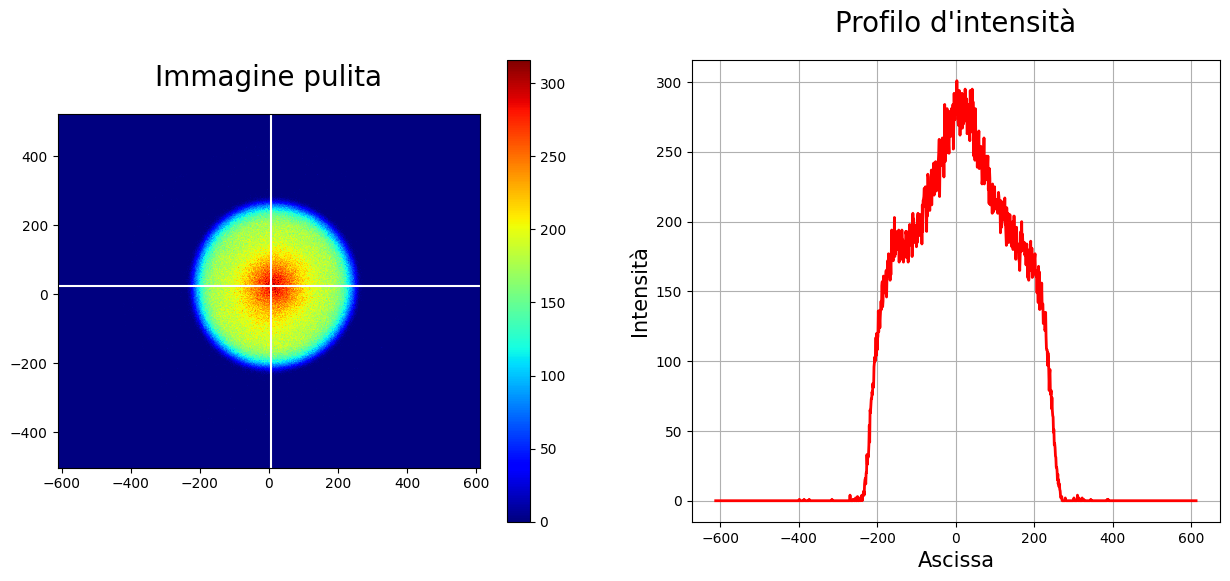

In [344]:
#--------------------------------------------------#
#     Testo i metodi --> prima fase di pulizia     #
#--------------------------------------------------#
xcen = 612; ycen = 502; r_pl = 320; rtrap = 419

rum_med = mean_noise("Dati/CAMimages/dark/dark", 80) 

plasma = np.array(Image.open("Dati/CAMimages/series8_225ms/plasma005.tif"))
plasma = plasma.reshape(1024, 1224)

x = np.linspace(-xcen, col - xcen, col)
y = np.linspace(-ycen, row - ycen, row)

plasma = no_rifl_off(plasma, rtrap, x, y, 10)



#--------------------------------------------------------------#
#     Testo i metodi --> output per visualizzare risultati     #
#--------------------------------------------------------------#

fig = plt.figure(figsize=(15, 6))

x = np.linspace(-xcen, col - xcen, col)
y = np.linspace(-ycen, row - ycen, row)

X, Y = np.meshgrid(x, y)

#-------------------------------------------------------------#
#              Immagine di plasma: esterno nullo              #
#-------------------------------------------------------------# 
ax = fig.add_subplot(1, 2, 1)

cax = ax.pcolormesh(X, Y, plasma, cmap='jet')
plt.colorbar(cax); ax.set_aspect('equal')
ax.set_title(f'Evoluzione libera: 225 ms', fontsize = 20, pad = 20)
plt.axhline(y=25, color='w', linestyle='-')
plt.axvline(x=5, color='w', linestyle='-')

#-------------------------------------------------------------#
#                      Profilo d'intensità                    #
#-------------------------------------------------------------# 
ax = fig.add_subplot(1, 2, 2); prof = plasma[527,:]

ax.plot(x, prof, color = 'r', linestyle = '-',linewidth = 2)
ax.set_xlabel("Ascissa", fontsize = 15); ax.set_ylabel("Intensità", fontsize = 15); ax.grid(True)
ax.set_title(f"Profilo d'intensità", fontsize = 20, pad = 20)

plt.show()

del x, y, X, Y
del prof, plasma, rum_med
del xcen, ycen, r_pl, rtrap

Procediamo ora con il calcolo dell'offset con 225 ms di evoluzione libera. Individuo aprendo uno ad uno i segnali indotti sul settore S2B in modo tale da identificare quali risultino ripertibili e quali no.

In [470]:
rip225 = [1, 2, 3, 5, 6, 7, 9, 10]

In [473]:
xcen = 612; ycen = 502; intlim = 10; rtrap = 419
off_225 = off_ottico('Dati/CAMimages/series8_225ms/plasma', rip225, rtrap, xcen, ycen, intlim)

print("L'offset medio con 225 ms di evoluzione libera è pari a: ", round(off_225, 4))
del xcen, ycen, intlim, rtrap

L'offset medio con 225 ms di evoluzione libera è pari a:  31.9991


<center>

### Evoluzione libera: 250 ms

</center>

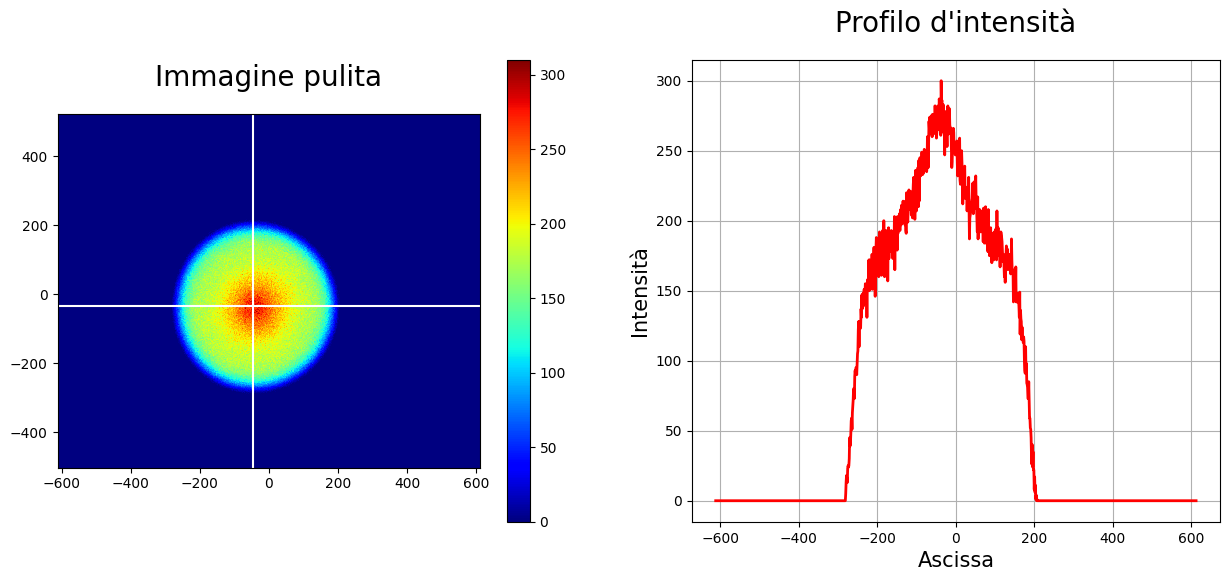

In [477]:
#--------------------------------------------------#
#     Testo i metodi --> prima fase di pulizia     #
#--------------------------------------------------#
xcen = 612; ycen = 502; r_pl = 320; rtrap = 419

rum_med = mean_noise("Dati/CAMimages/dark/dark", 80) 

plasma = np.array(Image.open("Dati/CAMimages/series3_250ms/plasma005.tif"))
plasma = plasma.reshape(1024, 1224)

x = np.linspace(-xcen, col - xcen, col)
y = np.linspace(-ycen, row - ycen, row)

plasma = no_rifl_off(plasma, rtrap, x, y, 10)



#--------------------------------------------------------------#
#     Testo i metodi --> output per visualizzare risultati     #
#--------------------------------------------------------------#

fig = plt.figure(figsize=(15, 6))

x = np.linspace(-xcen, col - xcen, col)
y = np.linspace(-ycen, row - ycen, row)

X, Y = np.meshgrid(x, y)

#-------------------------------------------------------------#
#              Immagine di plasma: esterno nullo              #
#-------------------------------------------------------------# 
ax = fig.add_subplot(1, 2, 1)

cax = ax.pcolormesh(X, Y, plasma, cmap='jet')
plt.colorbar(cax); ax.set_aspect('equal')
ax.set_title(f'Evoluzione libera: 250 ms', fontsize = 20, pad = 20)
plt.axhline(y=-35, color='w', linestyle='-')
plt.axvline(x=-45, color='w', linestyle='-')

#-------------------------------------------------------------#
#                      Profilo d'intensità                    #
#-------------------------------------------------------------# 
ax = fig.add_subplot(1, 2, 2); prof = plasma[467,:]

ax.plot(x, prof, color = 'r', linestyle = '-',linewidth = 2)
ax.set_xlabel("Ascissa", fontsize = 15); ax.set_ylabel("Intensità", fontsize = 15); ax.grid(True)
ax.set_title(f"Profilo d'intensità", fontsize = 20, pad = 20)

plt.show()

del x, y, X, Y
del prof, plasma, rum_med
del xcen, ycen, r_pl, rtrap

Procediamo ora con il calcolo dell'offset con 250 ms di evoluzione libera. Individuo aprendo uno ad uno i segnali indotti sul settore S2B in modo tale da identificare quali risultino ripertibili e quali no.

In [481]:
rip250 = [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 56, 57, 58, 59, 60, 61, 62]

In [482]:
xcen = 612; ycen = 502; intlim = 10; rtrap = 419
off_250 = off_ottico('Dati/CAMimages/series3_250ms/plasma', rip225, rtrap, xcen, ycen, intlim)

print("L'offset medio con 250 ms di evoluzione libera è pari a: ", round(off_250, 4))
del xcen, ycen, intlim, rtrap

L'offset medio con 250 ms di evoluzione libera è pari a:  44.3433


<center>

### Evoluzione libera: 275 ms

</center>

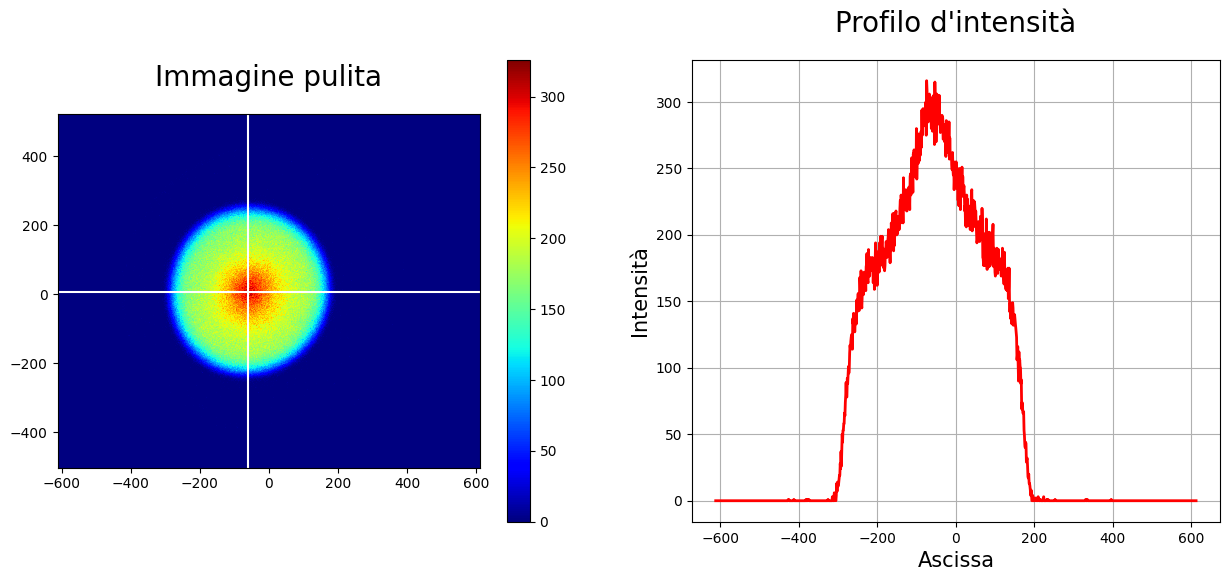

In [485]:
#--------------------------------------------------#
#     Testo i metodi --> prima fase di pulizia     #
#--------------------------------------------------#
xcen = 612; ycen = 502; r_pl = 320; rtrap = 419

rum_med = mean_noise("Dati/CAMimages/dark/dark", 80) 

plasma = np.array(Image.open("Dati/CAMimages/series9_275ms/plasma005.tif"))
plasma = plasma.reshape(1024, 1224)

x = np.linspace(-xcen, col - xcen, col)
y = np.linspace(-ycen, row - ycen, row)

plasma = no_rifl_off(plasma, rtrap, x, y, 10)



#--------------------------------------------------------------#
#     Testo i metodi --> output per visualizzare risultati     #
#--------------------------------------------------------------#

fig = plt.figure(figsize=(15, 6))

x = np.linspace(-xcen, col - xcen, col)
y = np.linspace(-ycen, row - ycen, row)

X, Y = np.meshgrid(x, y)

#-------------------------------------------------------------#
#              Immagine di plasma: esterno nullo              #
#-------------------------------------------------------------# 
ax = fig.add_subplot(1, 2, 1)

cax = ax.pcolormesh(X, Y, plasma, cmap='jet')
plt.colorbar(cax); ax.set_aspect('equal')
ax.set_title(f'Evoluzione libera: 275 ms', fontsize = 20, pad = 20)
plt.axhline(y=5, color='w', linestyle='-')
plt.axvline(x=-60, color='w', linestyle='-')

#-------------------------------------------------------------#
#                      Profilo d'intensità                    #
#-------------------------------------------------------------# 
ax = fig.add_subplot(1, 2, 2); prof = plasma[507,:]

ax.plot(x, prof, color = 'r', linestyle = '-',linewidth = 2)
ax.set_xlabel("Ascissa", fontsize = 15); ax.set_ylabel("Intensità", fontsize = 15); ax.grid(True)
ax.set_title(f"Profilo d'intensità", fontsize = 20, pad = 20)

plt.show()

del x, y, X, Y
del prof, plasma, rum_med
del xcen, ycen, r_pl, rtrap

Procediamo ora con il calcolo dell'offset con 275 ms di evoluzione libera. Individuo aprendo uno ad uno i segnali indotti sul settore S2B in modo tale da identificare quali risultino ripertibili e quali no.

In [486]:
rip275 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [488]:
xcen = 612; ycen = 502; intlim = 10; rtrap = 419
off_275 = off_ottico('Dati/CAMimages/series9_275ms/plasma', rip275, rtrap, xcen, ycen, intlim)

print("L'offset medio con 275 ms di evoluzione libera è pari a: ", round(off_275, 4))
del xcen, ycen, intlim, rtrap

L'offset medio con 275 ms di evoluzione libera è pari a:  55.5696


<center>

### Evoluzione libera: 300 ms

</center>

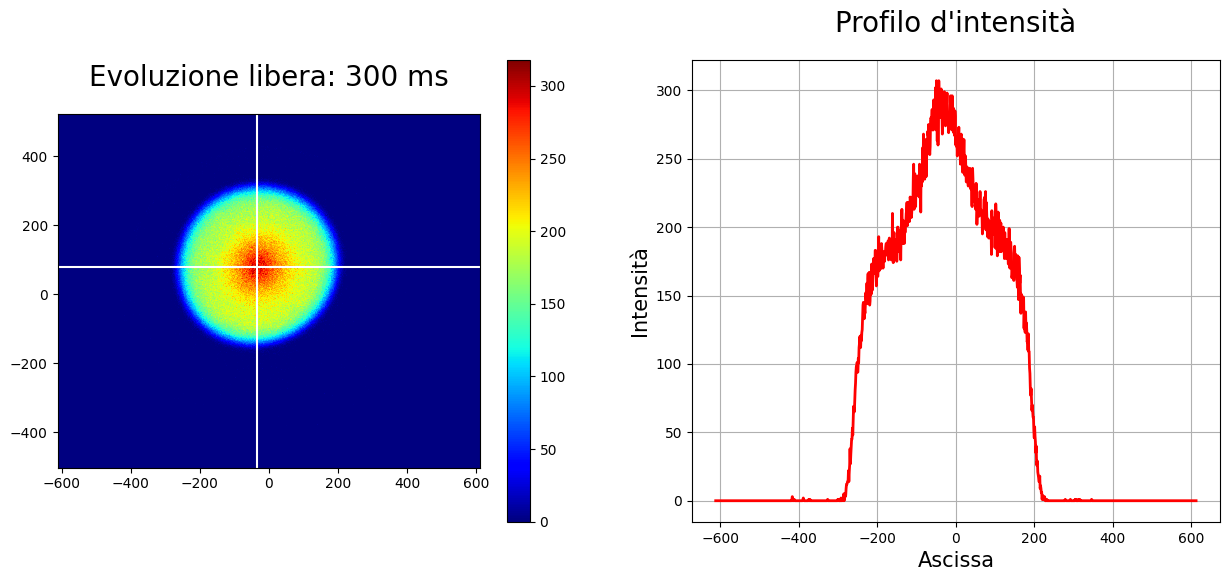

In [494]:
#--------------------------------------------------#
#     Testo i metodi --> prima fase di pulizia     #
#--------------------------------------------------#
xcen = 612; ycen = 502; r_pl = 320; rtrap = 419

rum_med = mean_noise("Dati/CAMimages/dark/dark", 80) 

plasma = np.array(Image.open("Dati/CAMimages/series2_300ms/plasma005.tif"))
plasma = plasma.reshape(1024, 1224)

x = np.linspace(-xcen, col - xcen, col)
y = np.linspace(-ycen, row - ycen, row)

plasma = no_rifl_off(plasma, rtrap, x, y, 10)



#--------------------------------------------------------------#
#     Testo i metodi --> output per visualizzare risultati     #
#--------------------------------------------------------------#

fig = plt.figure(figsize=(15, 6))

x = np.linspace(-xcen, col - xcen, col)
y = np.linspace(-ycen, row - ycen, row)

X, Y = np.meshgrid(x, y)

#-------------------------------------------------------------#
#              Immagine di plasma: esterno nullo              #
#-------------------------------------------------------------# 
ax = fig.add_subplot(1, 2, 1)

cax = ax.pcolormesh(X, Y, plasma, cmap='jet')
plt.colorbar(cax); ax.set_aspect('equal')
ax.set_title(f'Evoluzione libera: 300 ms', fontsize = 20, pad = 20)
plt.axhline(y=80, color='w', linestyle='-')
plt.axvline(x=-35, color='w', linestyle='-')

#-------------------------------------------------------------#
#                      Profilo d'intensità                    #
#-------------------------------------------------------------# 
ax = fig.add_subplot(1, 2, 2); prof = plasma[582,:]

ax.plot(x, prof, color = 'r', linestyle = '-',linewidth = 2)
ax.set_xlabel("Ascissa", fontsize = 15); ax.set_ylabel("Intensità", fontsize = 15); ax.grid(True)
ax.set_title(f"Profilo d'intensità", fontsize = 20, pad = 20)

plt.show()

del x, y, X, Y
del prof, plasma, rum_med
del xcen, ycen, r_pl, rtrap

Procediamo ora con il calcolo dell'offset con 300 ms di evoluzione libera. Individuo aprendo uno ad uno i segnali indotti sul settore S2B in modo tale da identificare quali risultino ripertibili e quali no.

In [489]:
rip300 = [2, 3, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 23, 25, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]

In [496]:
xcen = 612; ycen = 502; intlim = 10; rtrap = 419
off_300 = off_ottico('Dati/CAMimages/series2_300ms/plasma', rip300, rtrap, xcen, ycen, intlim)

print("L'offset medio con 300 ms di evoluzione libera è pari a: ", round(off_300, 4))
del xcen, ycen, intlim, rtrap

L'offset medio con 300 ms di evoluzione libera è pari a:  82.6469
